In [3]:
""" 
NOTEBOOK :  ntbk_figures_clim_data.ipynb 

This notebook produces the figures for the paper: 

 Boosting ensemble size of climate fields using generative machine learning; a proof of concept
  by P. Gooya, R. Sospedra-Alfonso, and J. Exenberger submitted to XXXX

STATUS  : Complete - needs checking results in full detail
COMMENTS: (1) The boosted ensemble appears to capture the known assymetries in 
              anomalies for el nino vs la nina, seen in the population and training sample
          (2) The variance of population extremes seems off   
"""""

' \nNOTEBOOK :  ntbk_figures_clim_data.ipynb \n\nThis notebook produces the figures for the paper: \n\n Boosting ensemble size of climate fields using generative machine learning; a proof of concept\n  by P. Gooya, R. Sospedra-Alfonso, and J. Exenberger submitted to XXXX\n\nSTATUS  : Complete - needs checking results in full detail\nCOMMENTS: (1) The boosted ensemble appears to capture the known assymetries in \n              anomalies for el nino vs la nina, seen in the population and training sample\n          (2) The variance of population extremes seems off   \n'

In [4]:
import os
import yaml 
import gc

filename = f'{os.getcwd()[:-10]}/config.yaml'
with open(filename) as f:
    dict_yaml = yaml.load(f, Loader=yaml.loader.SafeLoader)

var            = dict_yaml['variable'][0]
dir_source     = dict_yaml['dir_source']
dir_frnt_out   = dict_yaml['dir_frnt_out']
dict_clm   = dict_yaml['data_clm_info']
list_data  = dict_yaml['list_data_raw'] + dict_yaml['list_data_clm']

In [5]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(1, f'{dir_source}')

from modules.data_load     import load_clm_data
from modules.info_plt      import plt_module
from modules.plot_package  import plot_ts, plot_hist, plot_qq, plot_map
from modules.util_analysis import enso_extremes
from modules.util_glbavg   import *

## Set Up ##

In [6]:
dir_out  = f'{dir_frnt_out}' 

In [7]:
dict_event_plt = plt_module().dict_event_plt
dict_clm_plt   = plt_module().dict_clm_plt

In [8]:
quantiles = np.linspace(start=0,stop=1,num=int(100))[1:-1]
quantiles_extreme = ['None', '0.75', '0.85']
events    = ['nino', 'nina']

## Load Data ##

In [9]:
dict_data = load_clm_data([key for key in list_data if key != 'train_sample'],
                          dict_clm)

population
====
clm_VAE1
====
clm_VAE2
====
clm_VAE3
====
clm_VAE1_
====
clm_VAE3_
====
clm_cVAE1
====
clm_cVAE2
====
clm_cVAE3
====


In [10]:
idisplay = False
if idisplay:
    for idata in list_data:
        display(dict_data[idata])

## Dictionaries ##

- Anomalies

In [11]:
dict_anom = {}
for idata in list_data:
    if idata == 'population' or idata == 'train_sample':
        coords_for_clim = ['year','realization']
    else:
        coords_for_clim = ['realization']
    dict_anom[idata] = dict_data[idata] - dict_data[idata].mean(coords_for_clim)


    if 'VAE' in idata:
        dict_anom[idata] = dict_anom[idata].where(dict_anom[idata] <= dict_anom['train_sample'].max() )  ### through out outliers
        dict_anom[idata] = dict_anom[idata].where(dict_anom[idata] >= dict_anom['train_sample'].min() ) ### through out outliers

- Quantiles

In [10]:
time_to_show = np.arange(1,13) 
dict_quantiles_flat = {}
for idata in list_data:
    print(idata)
    ds1 = dict_anom[idata][var].sel(time=time_to_show).values.flatten()
    ds1 = ds1[~np.isnan(ds1)]
    ds1_quantiles = np.quantile(ds1, quantiles, interpolation='nearest')
    dict_quantiles_flat[idata] = ds1_quantiles  # uses median .. 

population
train_sample
clm_VAE1
clm_VAE2
clm_VAE3
clm_VAE1_
clm_VAE3_
clm_cVAE1
clm_cVAE2
clm_cVAE3


- Figure 3: QQ Plot

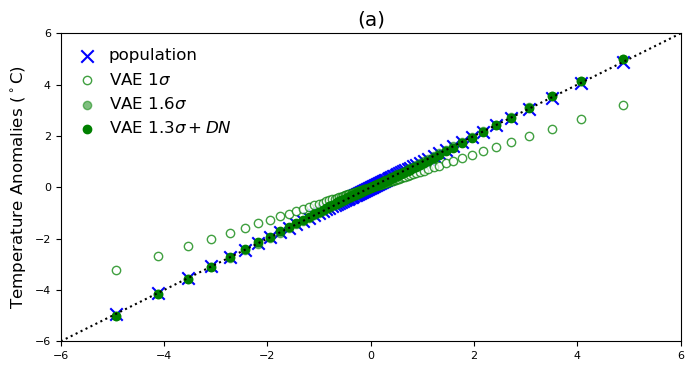

In [242]:
idata_ref = 'train_sample'
plot_qq([key for key in ['population','clm_VAE1', 'clm_VAE2' , 'clm_VAE3'] if key != idata_ref],
        dict_quantiles_flat,
        idata_ref=idata_ref,
        dict_plt=dict_clm_plt,
        box=[[-6,-6],
             [6,6]],
            figsize=(8,4),
        bbox=(-0.2,.5,.5,.5),
        title = '(a)',
        xlabel = '',
        dir_name= dir_frnt_out,
        file_name= 'Figure3_a',
        show=True,
        save=True)

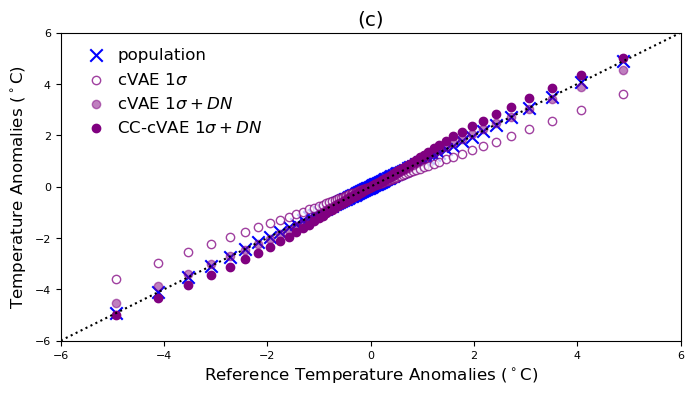

In [243]:
idata_ref = 'train_sample'
plot_qq([key for key in ['population','clm_cVAE1', 'clm_cVAE2' , 'clm_cVAE3'] if key != idata_ref],
        dict_quantiles_flat,
        idata_ref=idata_ref,
        dict_plt=dict_clm_plt,
        box=[[-6,-6],
             [6,6]],
            figsize=(8,4),
        bbox=(-0.15,.5,.5,.5),
        title = '(c)',
        dir_name= dir_frnt_out,
        file_name= 'Figure3_b',
        show=True,
        save=True)

- Nino 3.4

In [13]:
dict_enso = {}
for idata in list_data:
    dict_enso[idata] = dict_anom[idata].where((dict_anom[idata].lat >= -5) & (dict_anom[idata].lat<= 5),
                                              drop=True)
    dict_enso[idata] = dict_enso[idata].where((dict_enso[idata].lon >= 190) & (dict_enso[idata].lon<= 240),
                                              drop=True).mean(['lat','lon'])    

- Nino 3.4 Seasonal Cycle

In [14]:
dict_enso_seas_cycle = {}
for idata in list_data:
    dimension = ['realization','year']
    if idata not in ['population','train_sample']:
        dimension = 'realization'
    dict_enso_seas_cycle[idata] = dict_enso[idata].std(dimension)

- Figure 3: Nino3.4 Seasonal Cycle

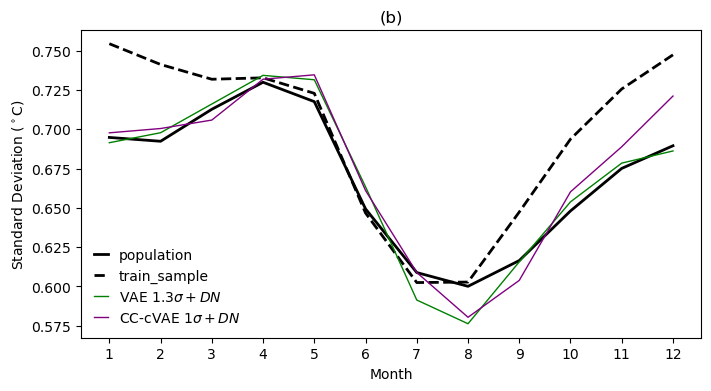

In [17]:
plot_ts(['population', 'train_sample', 'clm_VAE3', 'clm_cVAE3'],
        dict_enso_seas_cycle,
        dict_plot=dict_clm_plt,
        bbox= None, #(-0,-0.1,.5,.5),
        figsize=(8,4),
        title=f'(b)',
        xlabel=f'Month',
        ylabel=f'Standard Deviation ($^\circ$C)',
        dir_name= dir_frnt_out,
        file_name= 'Figure3_c',
        show=True,
        save=True)

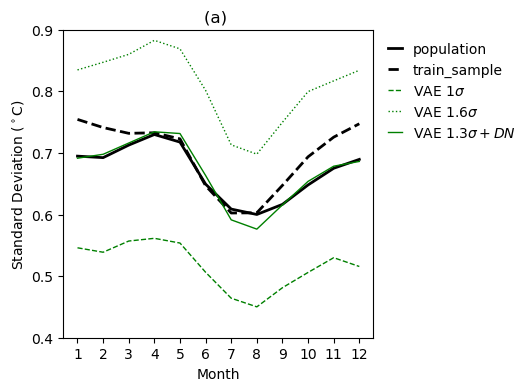

In [18]:
plot_ts(['population', 'train_sample', 'clm_VAE1', 'clm_VAE2', 'clm_VAE3'],
        dict_enso_seas_cycle,
        dict_plot=dict_clm_plt,
        bbox=(1,.5,.5,.5),
        title=f' (a) ',
        figsize=(4,4),
        xlabel=f'Month',
        ylim = [0.4,0.9],
                dir_name= dir_frnt_out,
        file_name= 'FigureS4_a',
        ylabel=f'Standard Deviation ($^\circ$C)',
        show=True,
        save=True)

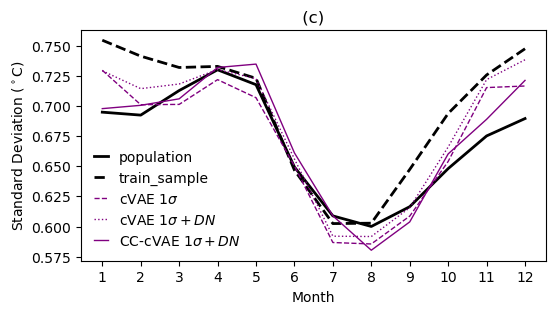

In [20]:
plot_ts(['population', 'train_sample', 'clm_cVAE1', 'clm_cVAE2', 'clm_cVAE3'],
        dict_enso_seas_cycle,
        dict_plot=dict_clm_plt,
        bbox=None, #(-0,.1,.5,.5),
        figsize=(6,3),
        title=f' (c) ',
        xlabel=f'Month',
        ylabel=f'Standard Deviation ($^\circ$C)',
        dir_name= dir_frnt_out,
        file_name= 'FigureS4_c',
        show=True,
        save=True)

- Figure 3: Histograms

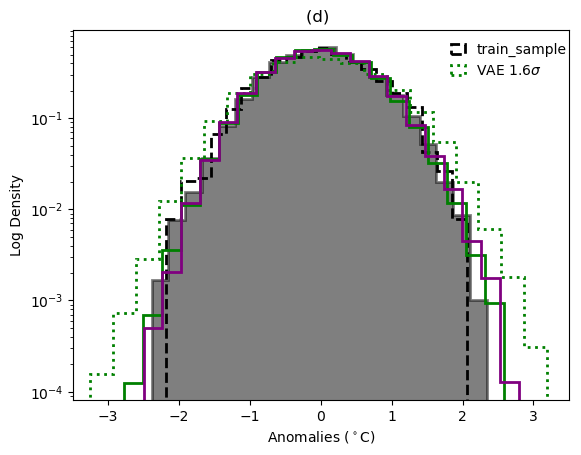

In [22]:
plot_hist(['population', 'train_sample','clm_VAE2', 'clm_VAE3','clm_cVAE3'],
          dict_enso,
          dict_clm_plt,
          season=np.arange(1,13),
          nbins=20,
          xlabel='Anomalies ($^\circ$C)',
          ylabel='Log Density',
          title='(d) ',
              fig_dir= dir_frnt_out,
          fig_name= 'Figure3_d',
          legend_bool = (False, True, True, False, False),
          bbox=(0.52,.5,.5,.5),
            xmin=-3.5,
            xmax=3.5,
          show = True,
          save = True)

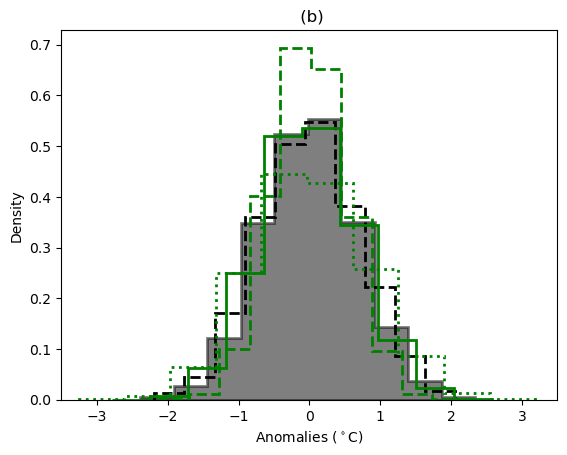

In [23]:
plot_hist(['population', 'train_sample','clm_VAE1', 'clm_VAE2', 'clm_VAE3'],
          dict_enso,
          dict_clm_plt,
          season=np.arange(1,13),
          nbins=10,
          xlabel='Anomalies ($^\circ$C)',
          ylabel='Density',
          title=' (b)',
          bbox=(.85,.5,.5,.5),
            xmin=-3.5,
            xmax=3.5,
            fig_dir= dir_frnt_out,
          fig_name= 'FigureS4_b',
            ylog = False,
          show = True,
          save = True)

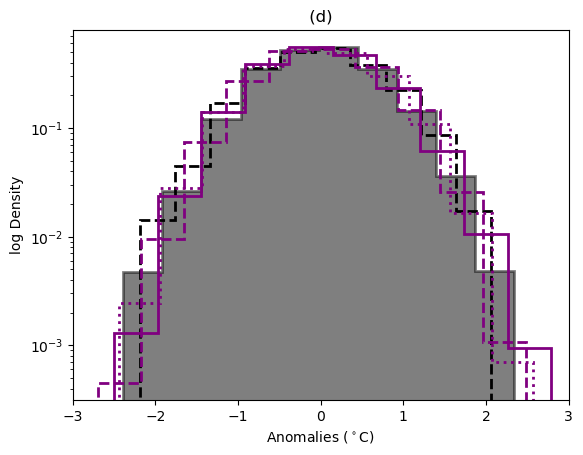

In [24]:
plot_hist(['population', 'train_sample','clm_cVAE1', 'clm_cVAE2', 'clm_cVAE3'],
          dict_enso,
          dict_clm_plt,
          season=np.arange(1,13),
          nbins=10,
          xlabel='Anomalies ($^\circ$C)',
          ylabel='log Density',
          title=' (d) ',
          bbox=(.9,.5,.5,.5),
            xmin=-3,
            xmax=3,
              fig_dir= dir_frnt_out,
          fig_name= 'FigureS4_d',
            ylog = True,
          show = True,
          save = True)

- Nino 3.4 Extremes

In [15]:

from tqdm import tqdm

dict_enso_extremes = {}
dict_enso_extremes['nino'] = {}
dict_enso_extremes['nina'] = {}
for idata in tqdm(list_data):
    dict_enso_extremes['nino'][idata] = {}
    dict_enso_extremes['nina'][idata] = {}
    for qq in [qq for qq in quantiles_extreme if qq != 'None']:
        (dict_enso_extremes['nino'][idata][qq], 
         dict_enso_extremes['nina'][idata][qq]) = enso_extremes(dict_anom[idata][var].load(),
                                                                dict_enso[idata][var].load(),
                                                                dict_enso['train_sample'][var].load(),
                                                                quantile=float(qq))    

100%|██████████| 10/10 [02:03<00:00, 12.39s/it]


In [16]:
for idata in tqdm([key for key in list_data if key != 'train_sample']):
    (dict_enso_extremes['nino'][idata]['None'], 
     dict_enso_extremes['nina'][idata]['None'])  = enso_extremes(dict_anom[idata][var].load(),
                                                                 dict_enso[idata][var].load(),
                                                                 dict_enso['train_sample'][var].load(),
                                                                 quantile=None)    

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:10<00:00,  1.12s/it]


- Nino 3.4 Extremes (Mean and StdDev)

In [17]:
dict_enso_extremes_mean = {}
dict_enso_extremes_std  = {}
for event in events:
    dict_enso_extremes_mean[event] = {}
    dict_enso_extremes_std[event]  = {}
    for idata in list_data:
        dict_enso_extremes_mean[event][idata] = {}
        dict_enso_extremes_std[event][idata]  = {}
        for qq in quantiles_extreme:
            dict_enso_extremes_mean[event][idata][qq] = {}
            dict_enso_extremes_std[event][idata][qq]  = {}

In [18]:

for event in dict_enso_extremes.keys():
    for idata in list_data:
        dimension = ['realization','year']
        if idata not in ['population','train_sample']:
            dimension = ['realization']
        for qq in [qq for qq in quantiles_extreme if qq != 'None']:
            dict_enso_extremes_mean[event][idata][qq] = dict_enso_extremes[event][idata][qq].mean(dimension)
            dict_enso_extremes_std[event][idata][qq]  = dict_enso_extremes[event][idata][qq].std(dimension)

In [19]:
qq = 'None'
time_to_show = np.arange(1,13)
for event in dict_enso_extremes.keys():
    for idata in [key for key in list_data if key != 'train_sample']:
        dimension = ['realization','year','time']
        if idata not in ['population','train_sample']:
            dimension = ['realization','time']
        
        dict_enso_extremes_mean[event][idata][qq] = dict_enso_extremes[event][idata][qq].sel(time=time_to_show).mean(dimension)
        dict_enso_extremes_std[event][idata][qq]  = dict_enso_extremes[event][idata][qq].sel(time=time_to_show).std(dimension)

- Figure 5: Mean Extreme Maps

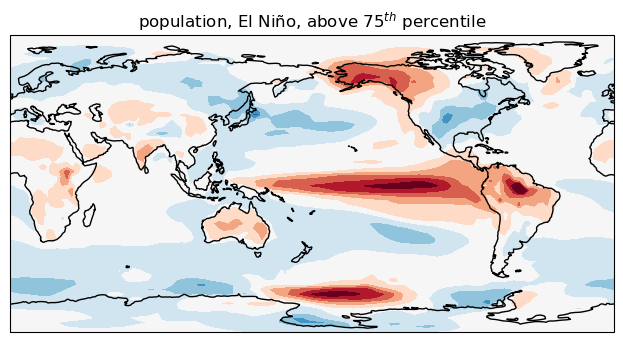

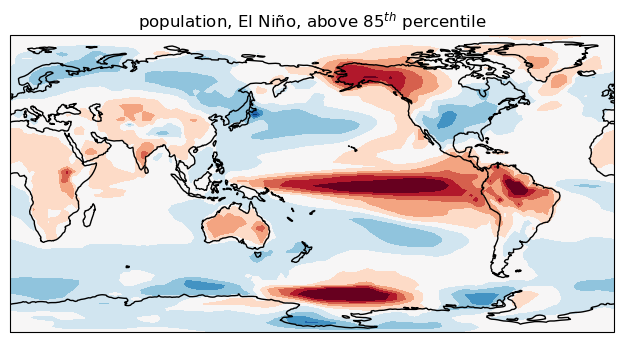

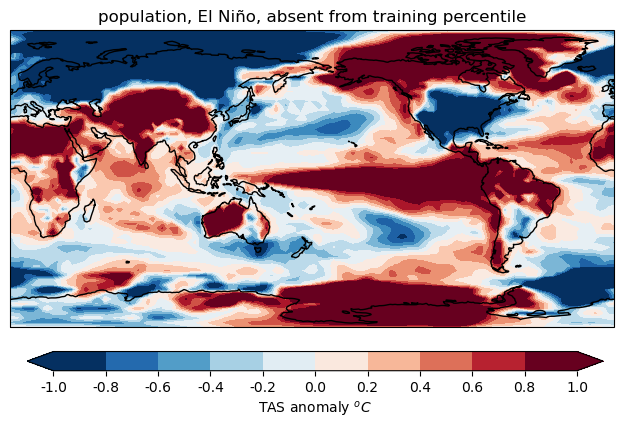

In [20]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'population'

for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    cbar_label = 'TAS anomaly $^{o}C$',
                    fig_dir=f'{dir_out}',
                    fig_name=f'Figure5_{panel}',
                    show=True,
                    save=True)
    except:
            print(f'{qq} quantile El Niño for {idata} non-existent!')

In [ ]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'train_sample'

for qq in quantiles_extreme:
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile = qq
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            quantile = 'absent from training'
            
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, {event}, quantile = {quantile}',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=True,
                    fig_dir=f'{dir_out}',
                    fig_name=f'map_mean_{dict_clm_plt[idata]["label"]}_{event}_N{qq[2:4]}',
                    show=True,
                    save=False)
    except:
            print(f'{qq} quantile {event} for {idata} non-existent!')

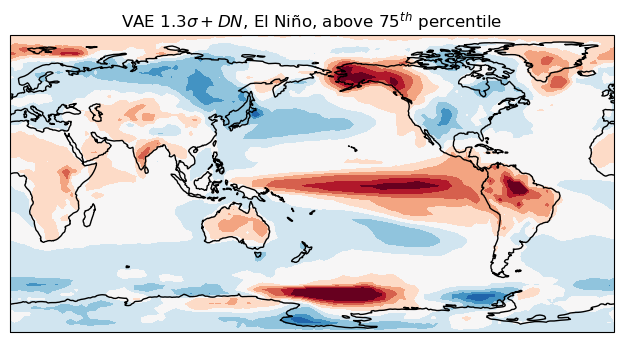

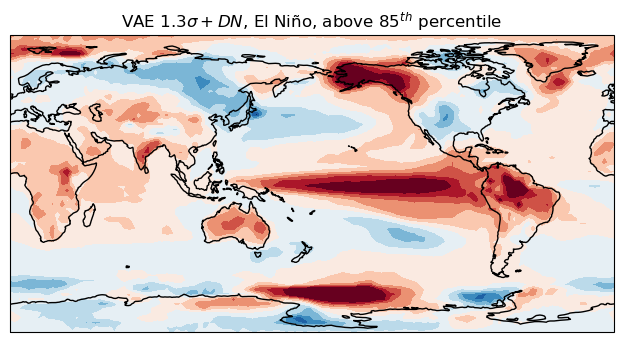

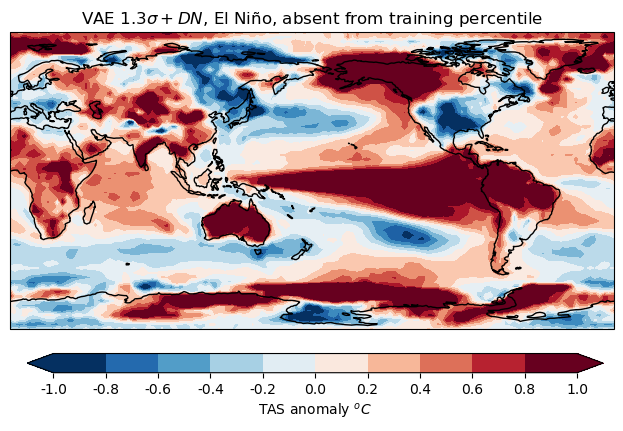

In [24]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'clm_VAE3'

for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS7_{panel}',
                    cbar_label = 'TAS anomaly $^{o}C$',
                    show=True,
                    save=True)
    except:
            print(f'{qq} quantile {event} for {idata} non-existent!')

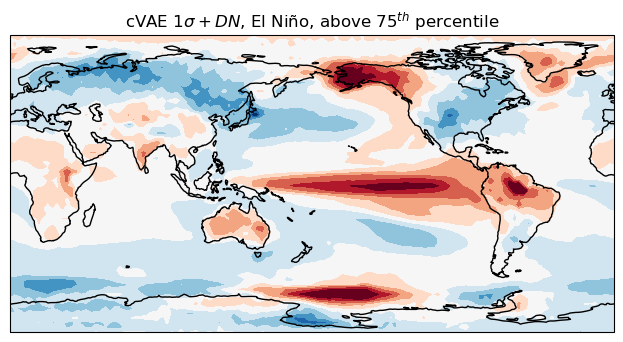

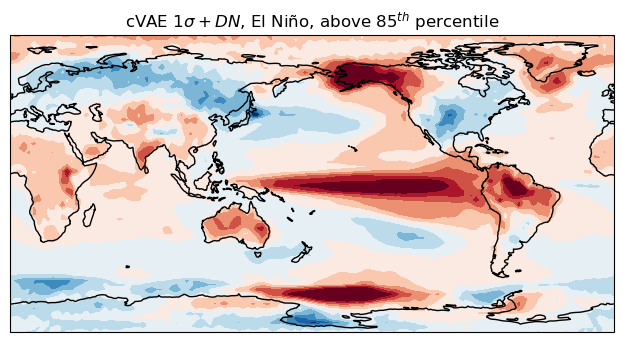

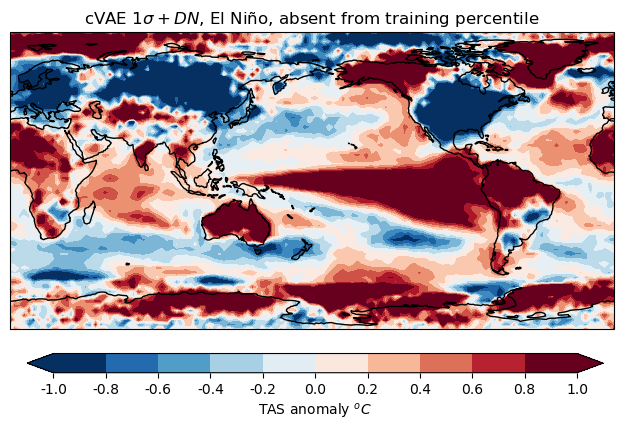

In [25]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'clm_cVAE2'

for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS8_{panel}',
                    cbar_label = 'TAS anomaly $^{o}C$',
                    show=True,
                    save=True)
    except:
            print(f'{qq} quantile {event} for {idata} non-existent!')

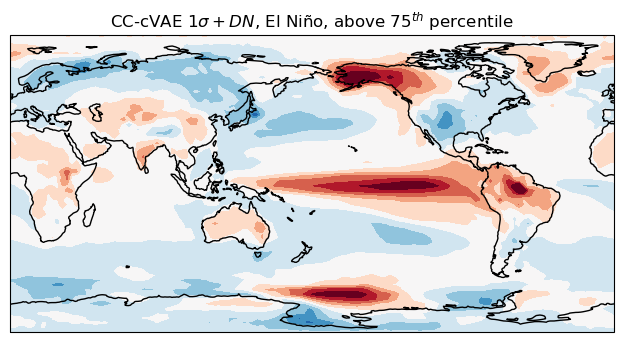

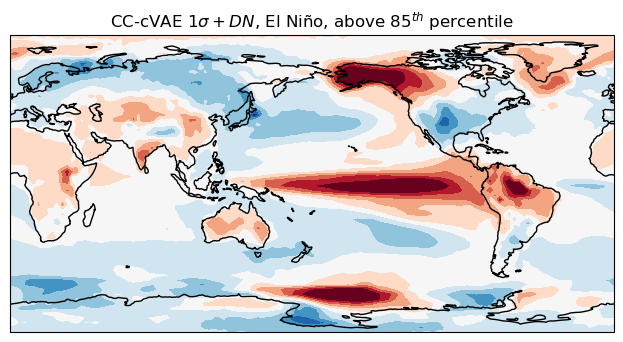

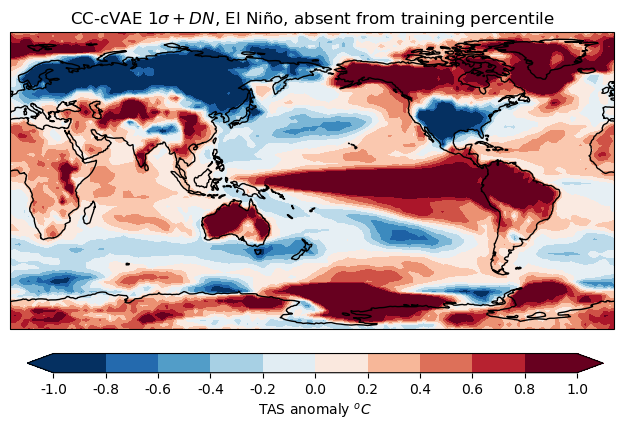

In [23]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'clm_cVAE3'

for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'Figure5_{panel}',
                    cbar_label = 'TAS anomaly $^{o}C$',
                    show=True,
                    save=True)
    except:
            print(f'{qq} quantile {event} for {idata} non-existent!')

- Figure 6: Standard Deviation Extreme Maps

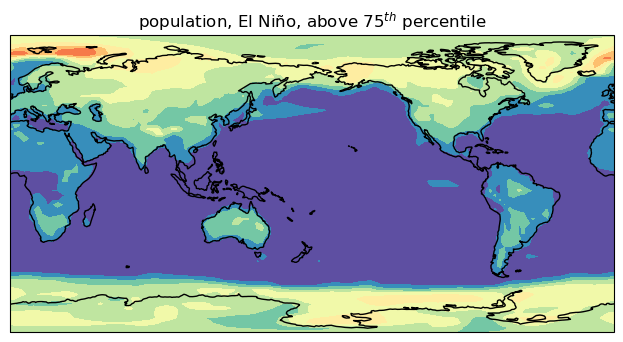

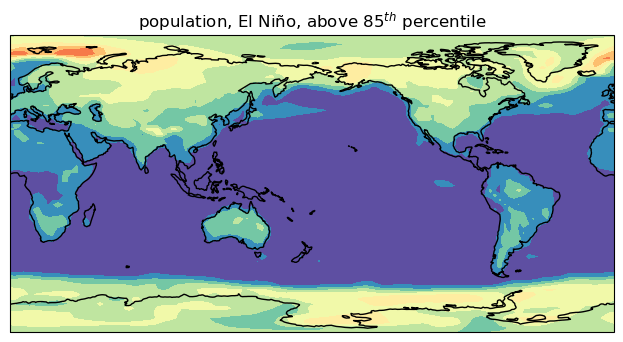

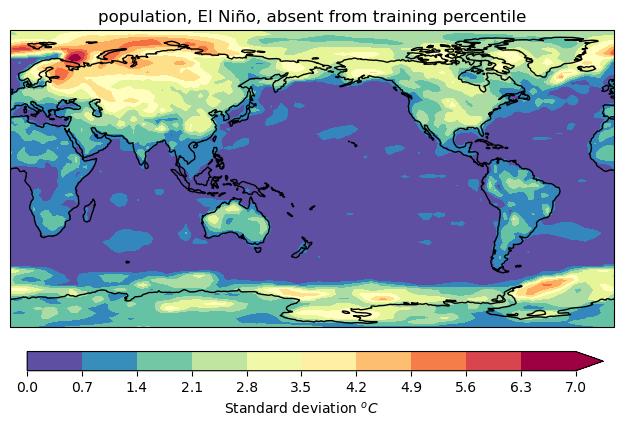

In [26]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'population'
for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
            
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    
                    fig_dir=f'{dir_out}',
                    fig_name=f'Figure6_{panel}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

In [ ]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'train_sample'
for qq in quantiles_extreme:
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, {event}, quantile = {qq}',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=True,
                    fig_dir=f'{dir_out}',
                    fig_name=f'map_std_{dict_clm_plt[idata]["label"]}_{event}_N{qq[2:4]}',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

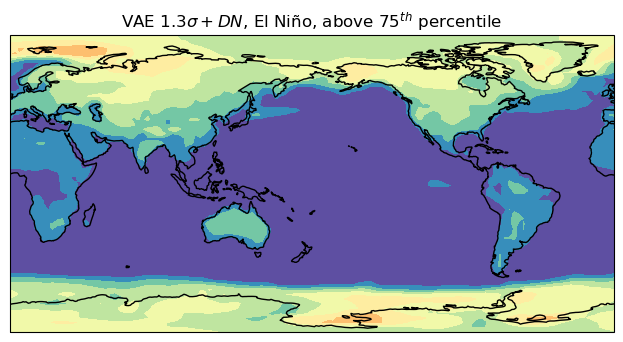

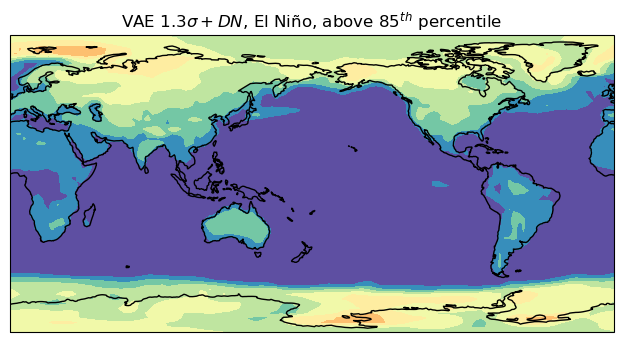

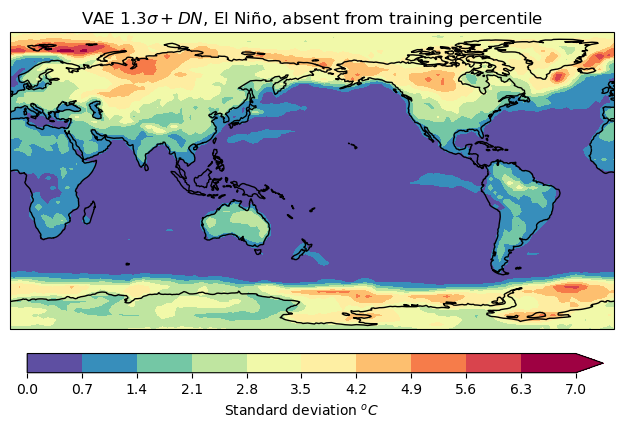

In [27]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'clm_VAE3'
for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    fig_name=f'FigureS7_{panel}',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

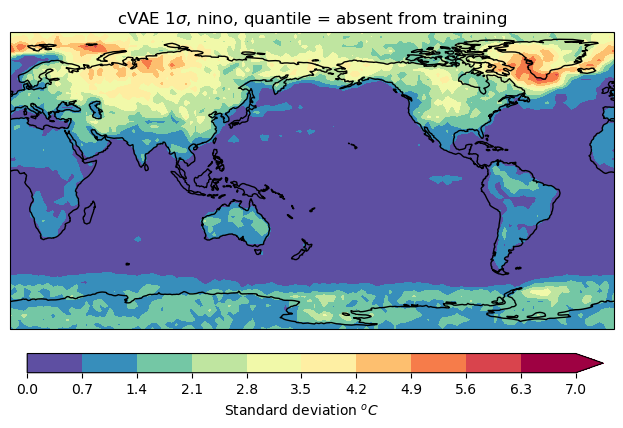

In [ ]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'clm_cVAE1'
for qq in ['None']:
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            quantile = 'absent from training'
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=True,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS8_g',
                    cbar_label = 'Standard deviation $^{o}C$',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

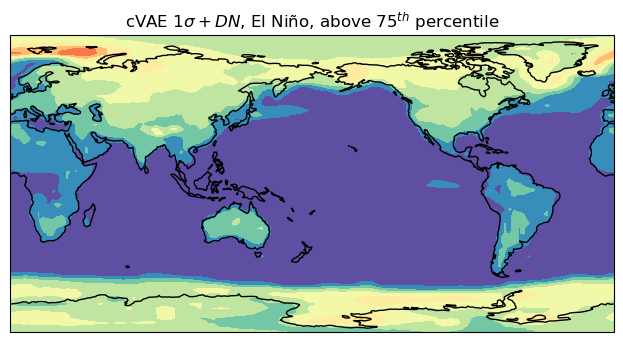

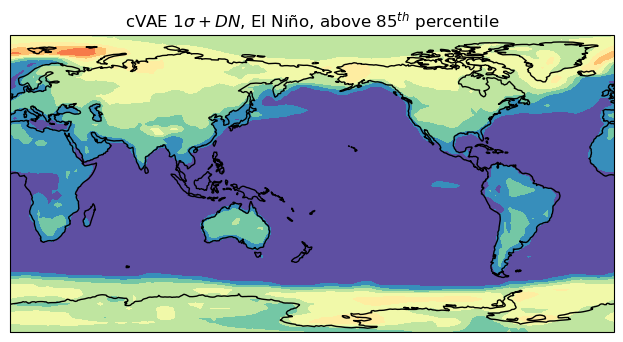

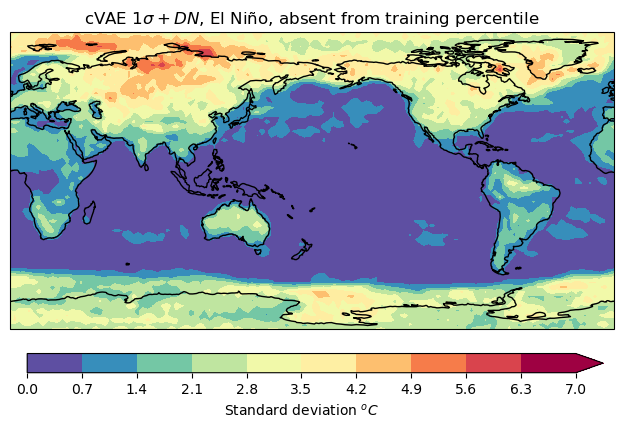

In [28]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'clm_cVAE2'
for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS8_{panel}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

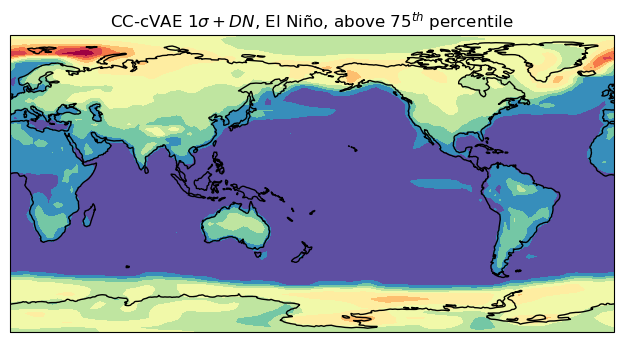

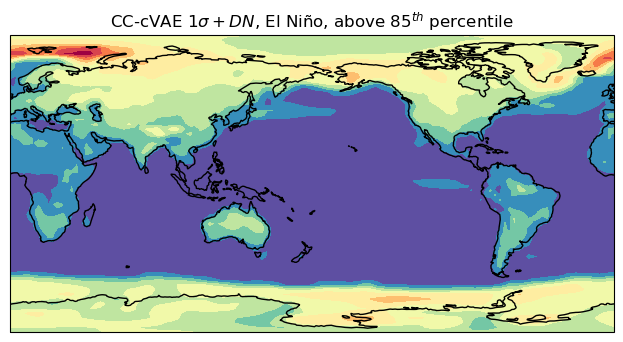

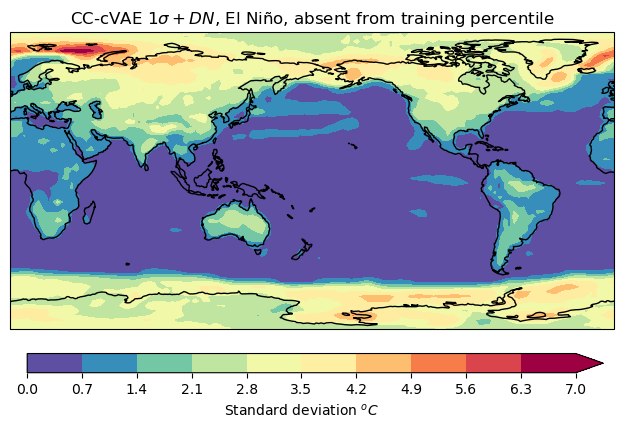

In [29]:
time_to_show = np.arange(1,13) #[1]
event = 'nino'
idata = 'clm_cVAE3'
for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile =  'above ' + str(int(eval(qq) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, El Niño, {quantile} percentile',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'Figure6_{panel}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

- La Nina S9-10

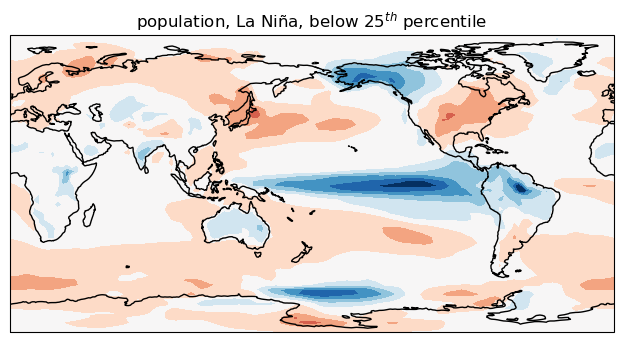

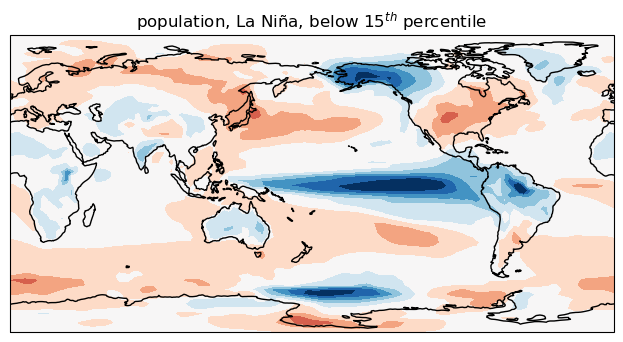

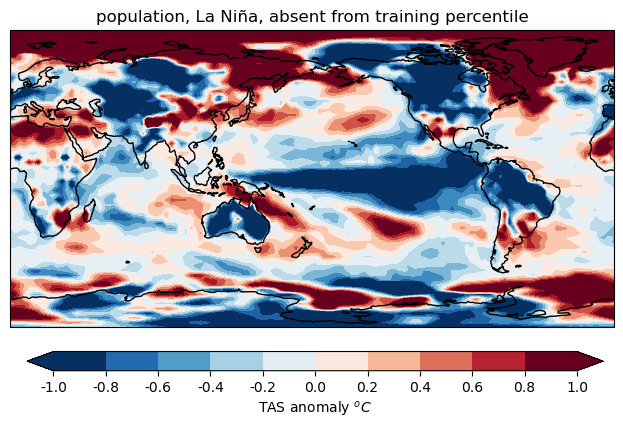

In [31]:
time_to_show = np.arange(1,13) #[1]
event = 'nina'
idata = 'population'

for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile = f'{np.round(1- eval(qq),2)}'
            quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            quantile = 'absent from training'

        cbar = True if panel == 'c' else False

        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    cbar_label = 'TAS anomaly $^{o}C$',
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS9_{panel}',
                    show=True,
                    save=True)
    except:
            print(f'{qq} quantile {event} for {idata} non-existent!')

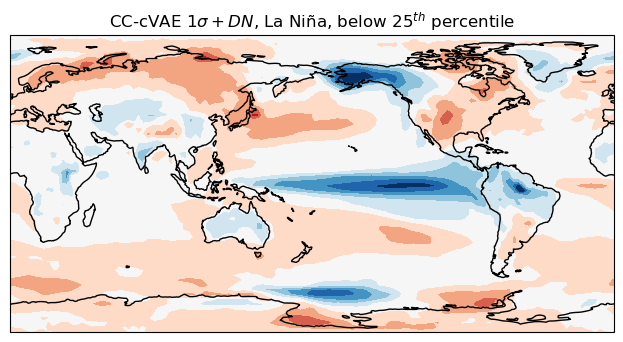

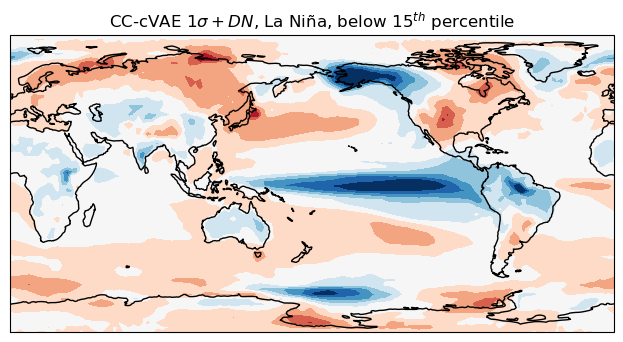

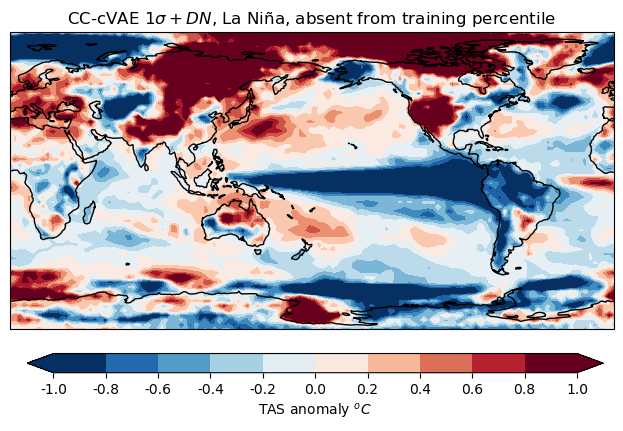

In [32]:
time_to_show = np.arange(1,13) #[1]
event = 'nina'
idata = 'clm_cVAE3'

for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_mean[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile = f'{np.round(1- eval(qq),2)}'
            quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_mean[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
                    vmin=dict_event_plt[event]['mean_vmin'],
                    vmax=dict_event_plt[event]['mean_vmax'],
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS9_{panel}',
                    cbar_label = 'TAS anomaly $^{o}C$',
                    show=True,
                    save=True)
    except:
            print(f'{qq} quantile {event} for {idata} non-existent!')

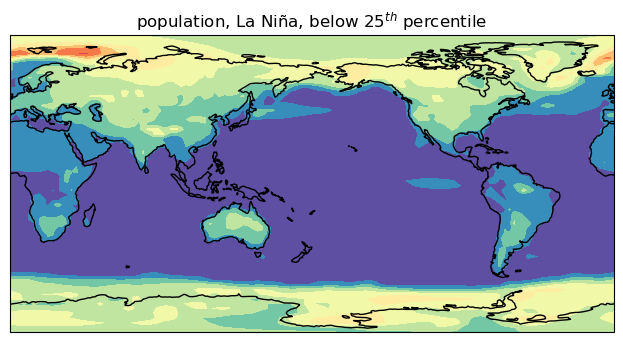

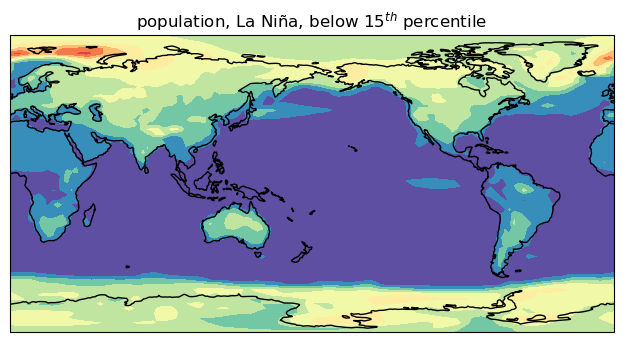

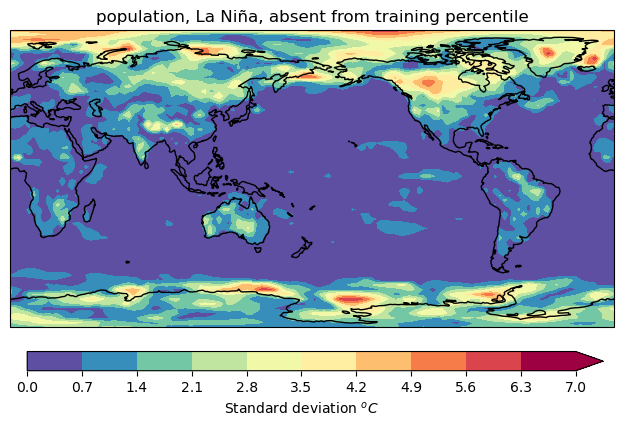

In [33]:
time_to_show = np.arange(1,13) #[1]
event = 'nina'
idata = 'population'
for panel, qq in zip(['a','b','c'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile = f'{np.round(1- eval(qq),2)}'
            quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'c' else False
            
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS10_{panel}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

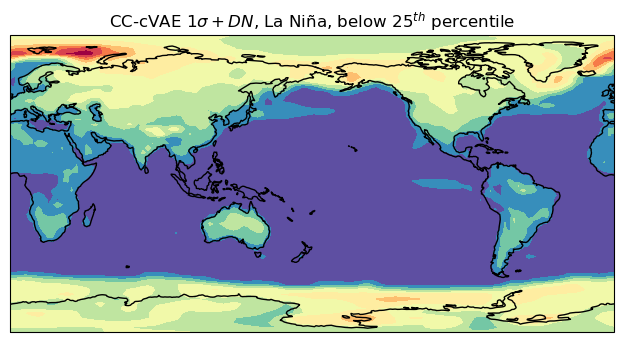

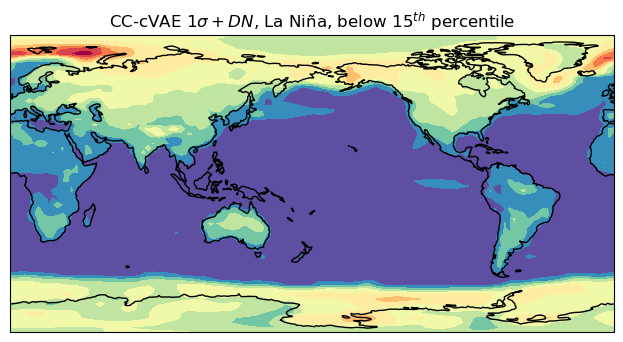

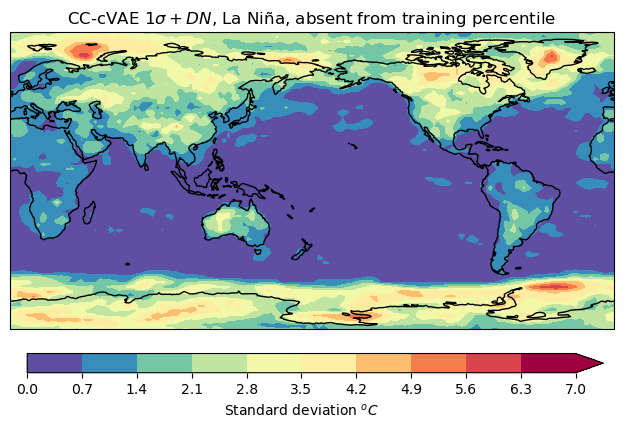

In [34]:
time_to_show = np.arange(1,13) #[1]
event = 'nina'
idata = 'clm_cVAE3'
for panel, qq in zip(['d','e','f'], ['0.75','0.85','None']):
    try:
        if qq != 'None':
            ds = dict_enso_extremes_std[event][idata][qq].sel(time=time_to_show).mean('time')
            quantile = f'{np.round(1- eval(qq),2)}'
            quantile = 'below ' + str(int(eval(quantile) *100)) + r'$^{th}$'
        else:
            ds = dict_enso_extremes_std[event][idata][qq]
            quantile = 'absent from training'
        cbar = True if panel == 'f' else False
        plot_map(ds,
                    title=f'{dict_clm_plt[idata]["label"]}, La Niña, {quantile} percentile',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                    cbar=cbar,
                    fig_dir=f'{dir_out}',
                    fig_name=f'FigureS10_{panel}',
                    cbar_label = 'Standard deviation $^{o}C$',
                    show=True,
                    save=True)
    except:
        print(f'{qq} quantile {event} for {idata} non-existent!')

- Figure 4 Latent space panels

In [35]:
from modules.util_latent import extract_latent_space_clim, prepare_data_for_AE_clim
from modules.util_analysis import doPCA
model_year = 49
n_components = 500
n_components_cond = 5

model_list = ['clm_VAE2', 'clm_VAE3', 'clm_cVAE2']

dict_mu = {}
dict_samples = {}
dict_emb = {}

for idata in model_list:
    model_dir = dict_clm[idata]['dir_in'].split('/tests')[0]
    data_dir = dict_clm['population']['dir_in'] + '/'+ dict_clm['population']['file_in'] + '.nc' 
    ds_in = xr.open_dataset(data_dir).load()[var]
    ds_in = ds_in.expand_dims('channels', axis=3).sortby('ensembles')  


    ds_train, ds_train_conds, params = prepare_data_for_AE_clim(ds_in, model_dir, model_year)
    ds_mu, ds_samples, ds_emb, ds_mu_cond, ds_var_cond, net, params =  extract_latent_space_clim(ds_train, ds_train_conds, params )


    if net.latent_size >2:

        PCAs = {}
        ds_samples,PCAs['samples'], explained_variance_ratio_ = doPCA(ds_samples, n_components=n_components)
        # print(f'ds_samples explained ratio : {explained_variance_ratio_}')
        ds_mu,pca,  explained_variance_ratio_ = doPCA(ds_mu, n_components=n_components) #, fitted_pca = PCAs['samples'])
        # print(f'ds_mu explained ratio : {explained_variance_ratio_}')

        if ds_emb is not None:
            ds_emb, PCAs['emb'], explained_variance_ratio_ = doPCA(ds_emb, n_components=n_components_cond)
            # print(f'ds_emb explained ratio : {explained_variance_ratio_}')

    dict_mu[idata] = ds_mu 
    dict_samples[idata] = ds_samples 
    dict_emb[idata] = ds_emb


Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=8192, out_features=3000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=3000, out_features=3000, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=3000, out_features=3000, bias=True)
    (7): ReLU()
    (8): Dropout(p=0, inplace=False)
    (9): Linear(in_features=3000, out_features=3000, bias=True)
    (10): ReLU()
    (11): Dropout(p=0, inplace=False)
  )
  (mu): Linear(in_features=3000, out_features=500, bias=True)
  (log_var): Linear(in_features=3000, out_features=500, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=500, out_features=3000, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=3000, out_features=3000, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=3000, out_features=3000, bias=True)
    (7): ReLU()
    (8): Dropout(p=0,

In [41]:
from pathlib import Path

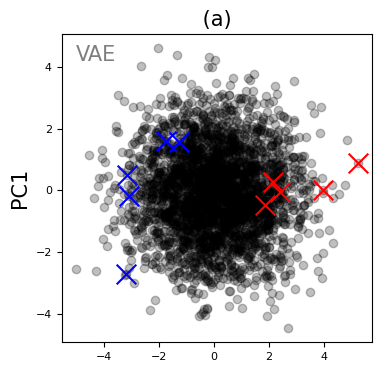

In [48]:
ds_train_enso = dict_enso['train_sample'][var][:-1].rename({'time' : 'lead_time' , 'realization' : 'ensembles'}).stack(time = ('year','lead_time')).transpose('time',...)
ds_mu = dict_mu['clm_VAE3']
label = 'VAE'


plt.figure(figsize=(4,4))
colors = [ 'r','g','b','k','c','olive','m','y','purple','tab:red','orange','tab:blue']

month_idx = 0
for t in range(0,len(ds_train_enso.time)):

    plt.subplot(1,1,1)      
    plt.scatter(ds_mu.sel(ensembles = params['ensemble_list'])[t+month_idx,:,0].values, ds_mu.sel(ensembles = params['ensemble_list'])[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}', color = 'k', alpha = 0.25)# colors[ds_train.lead_time[t].values])
    

plt.subplot(1,1,1) 

elnino_samples=  ds_mu.sel(ensembles = params['ensemble_list']).where(ds_train_enso > np.quantile(ds_train_enso,0.9985)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
lanina_samples=  ds_mu.sel(ensembles = params['ensemble_list']).where(ds_train_enso < np.quantile(ds_train_enso,0.0015)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
plt.scatter(elnino_samples.values[:,0], elnino_samples.values[:,1], color = 'r', marker = 'x', s = 200)
plt.scatter(lanina_samples.values[:,0], lanina_samples.values[:,1],  color = 'b', marker = 'x', s = 200)

plt.title(' (a) ' , fontsize = 15)
plt.text(-5,4.2, label, fontsize = 15, alpha = 0.5)

# plt.legend(bbox_to_anchor = (1,1))
# plt.xlabel('PCA2', fontsize = 15)
plt.ylabel('PC1', fontsize = 15)

plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)

Path(dir_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_out}/Figure4_a',
            bbox_inches='tight',
            dpi=300)

plt.show()

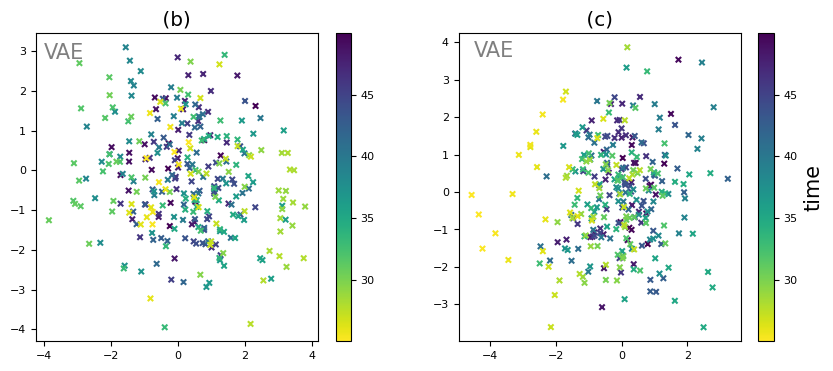

In [44]:
data = dict_mu['clm_VAE3'] # ds_samples

plt.figure(figsize = (10,4))
for ind, e in enumerate([7,8]):
    plt.subplot(1,2,ind+1)
    x = data[-300:,e-1,0].values
    y = data[-300:,e-1,1].values
    z = data.year.values[-300:] + (data.lead_time.values[-300:] - 0.5) /12
    # if ind == 1:
    x = np.flip(x)
    y = np.flip(y)
    z = np.flip(z)
    
    scatter = plt.scatter(x,y ,c=z, cmap='viridis_r', marker = 'x', s = 15)
    cbar = plt.colorbar(scatter)
    if ind == 1:
        
        cbar.set_label('time', fontsize = 15)
    if ind == 0 :
        panel = '(b)'
        plt.text(-4,2.8, 'VAE', fontsize = 15, alpha = 0.5)
    else:
        plt.text(-4.5,3.6, 'VAE', fontsize = 15, alpha = 0.5)
        panel = '(c)'
    plt.title(f' {panel} ')

    
Path(dir_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_out}/Figure4_bc',
            bbox_inches='tight',
            dpi=300)

plt.show()

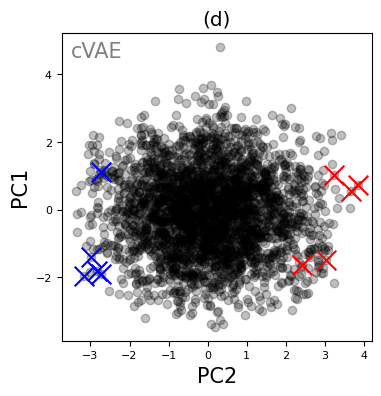

In [47]:
ds_mu = dict_mu['clm_cVAE2']
label = 'cVAE'

plt.figure(figsize=(4,4))
colors = [ 'r','g','b','k','c','olive','m','y','purple','tab:red','orange','tab:blue']

month_idx = 0
for t in range(0,len(ds_train_enso.time)):
    # plt.subplot(1,2,1)
    # plt.scatter(ds_samples.sel(ensembles = params['ensemble_list'])[t+month_idx,:,0].values, ds_samples.sel(ensembles = params['ensemble_list'])[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}', color = 'k' , alpha = 0.25)#colors[ds_train.lead_time[t].values])

    plt.subplot(1,1,1)      
    plt.scatter(ds_mu.sel(ensembles = params['ensemble_list'])[t+month_idx,:,0].values, ds_mu.sel(ensembles = params['ensemble_list'])[t+month_idx,:,1].values, label = f'{ds_mu.time[t+month_idx].values}', color = 'k', alpha = 0.25)# colors[ds_train.lead_time[t].values])
    



plt.subplot(1,1,1) 

elnino_samples=  ds_mu.sel(ensembles = params['ensemble_list']).where(ds_train_enso > np.quantile(ds_train_enso,0.9985)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
lanina_samples=  ds_mu.sel(ensembles = params['ensemble_list']).where(ds_train_enso < np.quantile(ds_train_enso,0.0015)).reset_index('time').stack(d = ('time','ensembles')).transpose(...,'mu').dropna('d')
plt.scatter(elnino_samples.values[:,0], elnino_samples.values[:,1], color = 'r', marker = 'x', s = 200)
plt.scatter(lanina_samples.values[:,0], lanina_samples.values[:,1],  color = 'b', marker = 'x', s = 200)

# plt.title('latent space encoding $\mu_{NN}$' + f' - {label}' , fontsize = 15)
plt.text(-3.5,4.5, label, fontsize = 15, alpha = 0.5)
# plt.legend(bbox_to_anchor = (1,1))
plt.xlabel('PC2', fontsize = 15)
plt.ylabel('PC1', fontsize = 15)
plt.title('(d)')
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)

Path(dir_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_out}/Figure4_d',
            bbox_inches='tight',
            dpi=300)

plt.show()

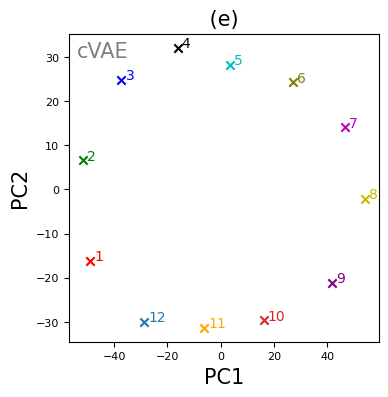

In [46]:
plt.figure(figsize=(4,4))
ds_emb = dict_emb['clm_cVAE2']
label = 'cVAE'
if ds_emb is not None:
    for t in range(0,len(ds_train_enso[:12].time)):
        month = ds_train.lead_time[t].values
        plt.scatter(ds_emb[t,0].values, ds_emb[t,1].values, color = colors[month-1], marker = 'x', label = f'month {month}')
        plt.text(ds_emb[t,0].values + 1.5, ds_emb[t,1].values , month,size = 10, color = colors[month-1])
    # plt.legend(bbox_to_anchor = (1,1)) 
    plt.title(' (e) ', fontsize = 15)
    plt.xlabel('PC1', fontsize = 15)
    plt.ylabel('PC2', fontsize = 15)
    plt.text(-54,30, label, fontsize = 15, alpha = 0.5)
    # plt.legend(bbox_to_anchor = (1,1))
Path(dir_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_out}/FigureS4_e',
            bbox_inches='tight',
            dpi=300)
plt.show()

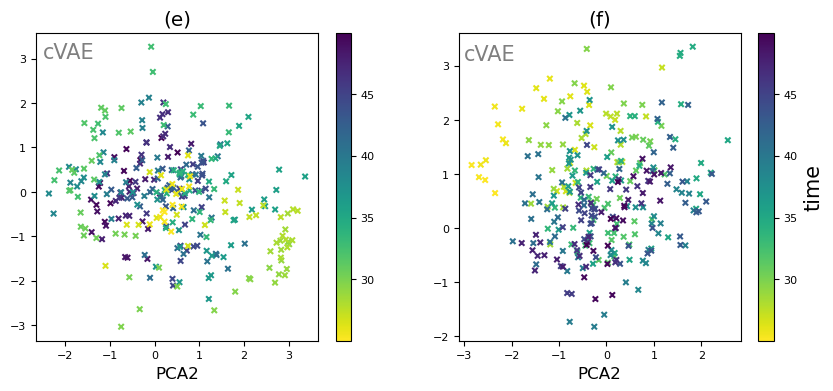

In [271]:
data = dict_mu['clm_cVAE2'] # ds_samples

plt.figure(figsize = (10,4))
for ind, e in enumerate([7,8]):
    plt.subplot(1,2,ind+1)
    x = data[-300:,e-1,0].values
    y = data[-300:,e-1,1].values
    z = data.year.values[-300:] + (data.lead_time.values[-300:] - 0.5) /12
    if ind == 0:
        x = np.flip(x)
        y = np.flip(y)
        z = np.flip(z)
    
    scatter = plt.scatter(x,y ,c=z, cmap='viridis_r', marker = 'x', s = 15)
    cbar = plt.colorbar(scatter)
    if ind == 1:
        cbar.set_label('time', fontsize = 15)
    # plt.title(f'Ensemble member {e}')
    if ind == 0 :
        # plt.ylabel('PCA1')
        label = '(e)'
        plt.text(-2.5,3,'cVAE', fontsize = 15, alpha = 0.5)
    else:
        label = '(f)'
        plt.text(-3,3.1, 'cVAE', fontsize = 15, alpha = 0.5)
    plt.title(label)
    plt.xlabel('PCA2')

Path(dir_out).mkdir(parents=True, exist_ok=True)
plt.savefig(f'{dir_out}/Figure4_ef',
            bbox_inches='tight',
            dpi=300)

plt.show()

- Figure S5

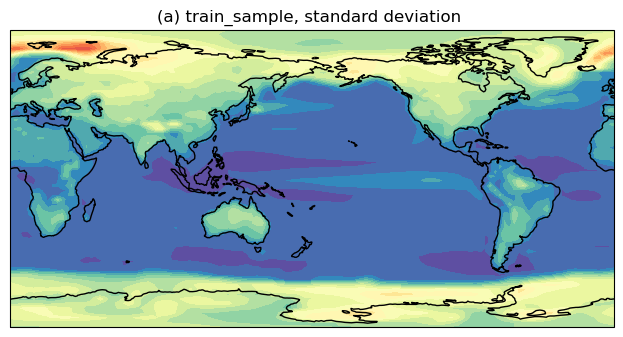

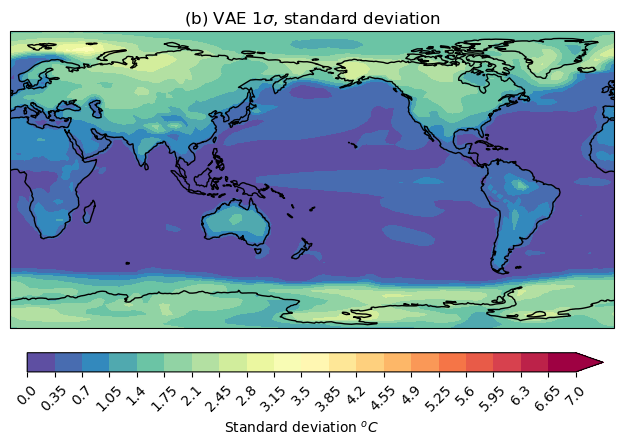

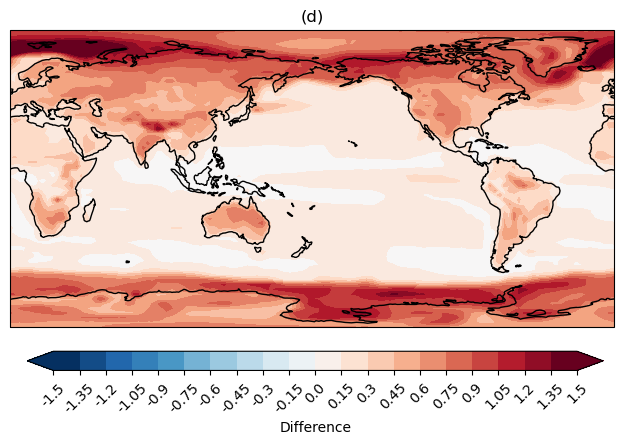

In [295]:
time_to_show = np.arange(1,13) #[1]

ds = dict_anom['train_sample'][var].sel(time=time_to_show).std(['year','realization']).sel(time = time_to_show).mean('time')

plot_map(ds,
                title=f'(a) {dict_clm_plt["train_sample"]["label"]}, standard deviation ',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=False,
                nvals = 20,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS5_a',
                show=True,
                save=True)

ds2 = dict_anom['clm_VAE1'][var].sel(time=time_to_show).std(['realization']).sel(time = time_to_show).mean('time')

plot_map(ds2,
                title=f'(b) {dict_clm_plt["clm_VAE1"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=True,
                nvals = 20,
                ticks_rotation = 45,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS5_b',
                cbar_label = 'Standard deviation $^{o}C$',
                show=True,
                save=True)


plot_map(ds - ds2,
                title=f'(d)',
                cbar=True,
                nvals = 20,
                fig_dir=f'{dir_out}',
                cbar_label = 'Difference',
                ticks_rotation = 45,
                fig_name=f'FigureS5_c',
                show=True,
                save=True)

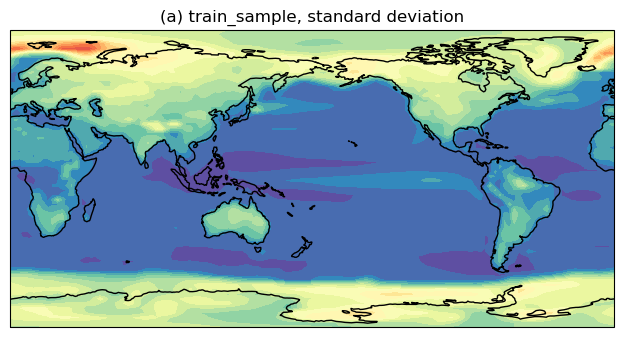

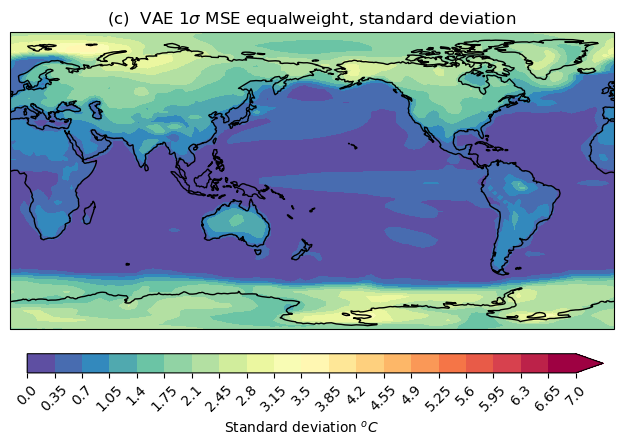

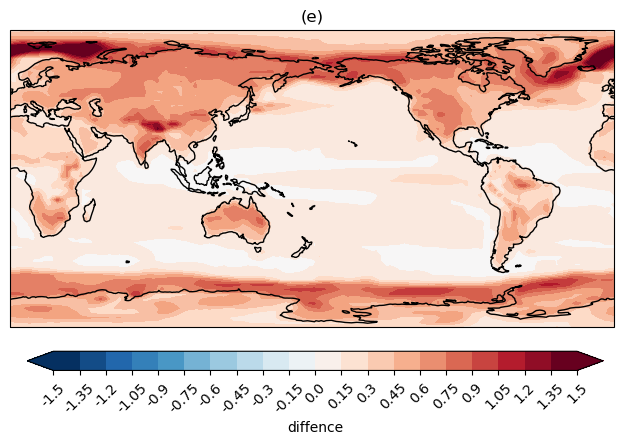

In [292]:
time_to_show = np.arange(1,13) #[1]

ds = dict_anom['train_sample'][var].sel(time=time_to_show).std(['year','realization']).sel(time = time_to_show).mean('time')

plot_map(ds,
                title=f'(a) {dict_clm_plt["train_sample"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=False,
                nvals = 20,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS5_a',
                show=True,
                save=False)

ds2 = dict_anom['clm_VAE1_'][var].sel(time=time_to_show).std(['realization']).sel(time = time_to_show).mean('time')

plot_map(ds2,
                title=f'(c)  {dict_clm_plt["clm_VAE1_"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=True,
                nvals = 20,
                ticks_rotation = 45,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS5_d',
                cbar_label = 'Standard deviation $^{o}C$',
                show=True,
                save=True)


plot_map(ds - ds2,
                title=f'(e)',
                cbar=True,
                nvals = 20,
                ticks_rotation = 45,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS5_e',
                cbar_label = 'diffence',
                show=True,
                save=True)

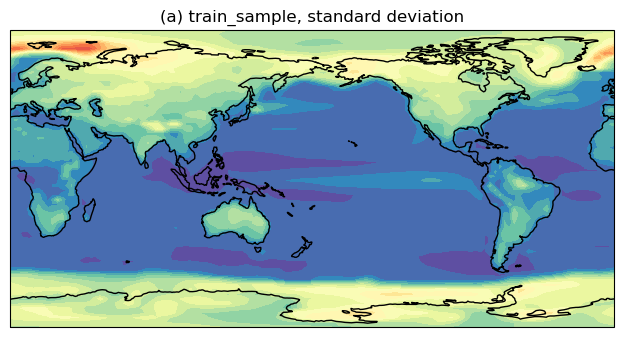

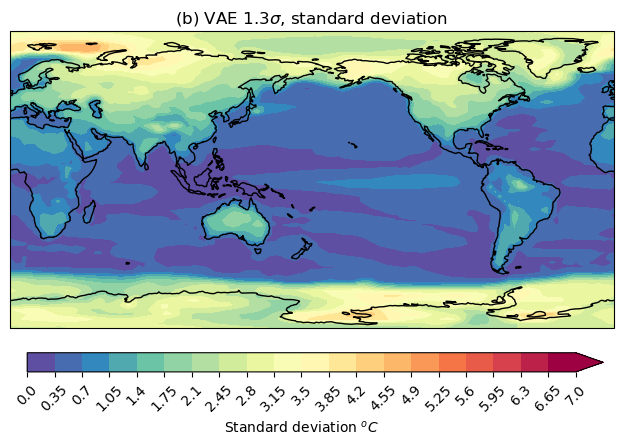

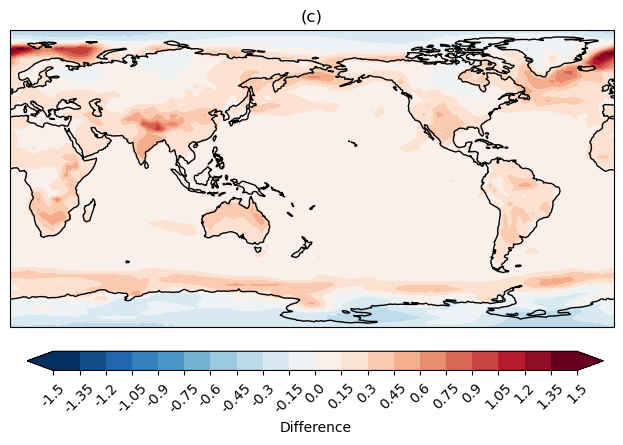

In [293]:
time_to_show = np.arange(1,13) #[1]

ds = dict_anom['train_sample'][var].sel(time=time_to_show).std(['year','realization']).sel(time = time_to_show).mean('time')

plot_map(ds,
                title=f'(a) {dict_clm_plt["train_sample"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=False,
                nvals = 20,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS6_a',
                show=True,
                save=True)

ds2 = dict_anom['clm_VAE3_'][var].sel(time=time_to_show).std(['realization']).sel(time = time_to_show).mean('time')

plot_map(ds2,
                title=f'(b) {dict_clm_plt["clm_VAE3_"]["label"]}, standard deviation ',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=True,
                nvals = 20,
                fig_dir=f'{dir_out}',
                ticks_rotation = 45,
                fig_name=f'FigureS6_b',
                cbar_label = 'Standard deviation $^{o}C$',
                show=True,
                save=True)


plot_map(ds - ds2,
                title=f'(c)',
                cbar=True,
                nvals = 20,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS6_c',
                ticks_rotation = 45,
                cbar_label = 'Difference',
                show=True,
                save=True)

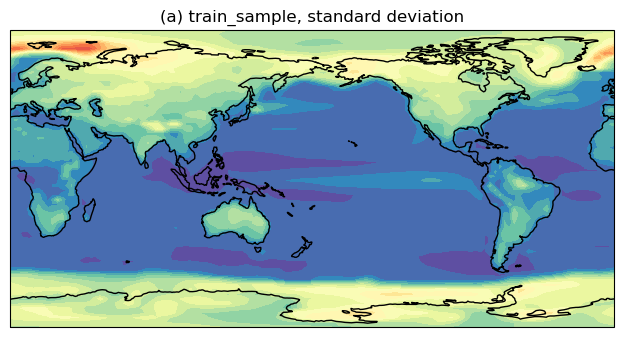

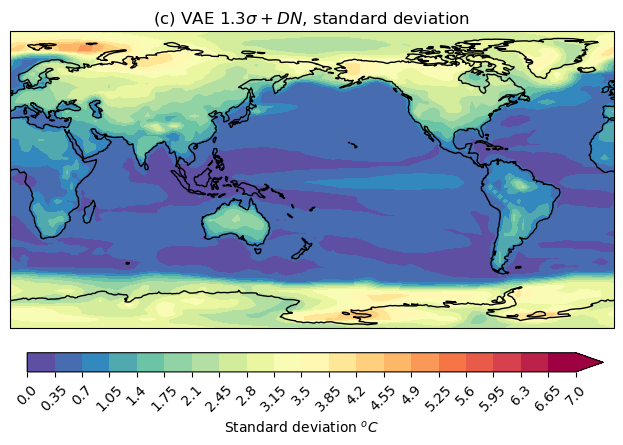

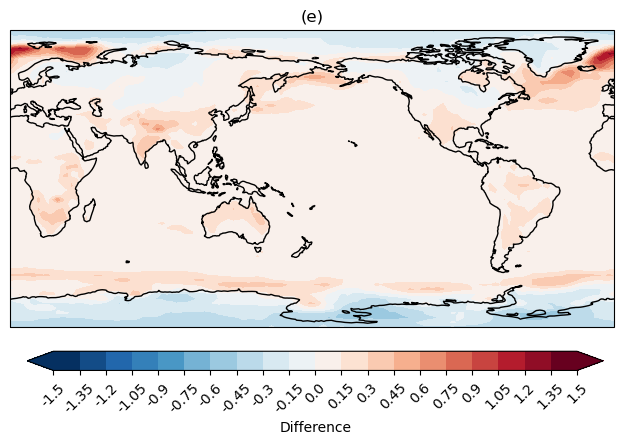

In [294]:
time_to_show = np.arange(1,13) #[1]

ds = dict_anom['train_sample'][var].sel(time=time_to_show).std(['year','realization']).sel(time = time_to_show).mean('time')

plot_map(ds,
                title=f'(a) {dict_clm_plt["train_sample"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=False,
                nvals = 20,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS6_a',
                show=True,
                save=False)

ds2 = dict_anom['clm_VAE3'][var].sel(time=time_to_show).std(['realization']).sel(time = time_to_show).mean('time')


plot_map(ds2,
                title=f'(c) {dict_clm_plt["clm_VAE3"]["label"]}, standard deviation',
                    vmin=dict_event_plt[event]['std_vmin'],
                    vmax=dict_event_plt[event]['std_vmax'],
                    cmap='Spectral_r',
                    cbar_extend='max',
                cbar=True,
                nvals = 20,
                ticks_rotation = 45,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS6_d',
                cbar_label = 'Standard deviation $^{o}C$',
                show=True,
                save=True)


plot_map(ds - ds2,
                title=f'(e)',
                cbar=True,
                nvals = 20,
                ticks_rotation = 45,
                fig_dir=f'{dir_out}',
                fig_name=f'FigureS6_e',
                cbar_label = 'Difference',
                show=True,
                save=True)